### Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image

from os import listdir
from glob import glob
from skimage.io import imread

import time
import copy
from tqdm import tqdm_notebook as tqdm

In [3]:
import tensorflow as tf
# Verify that TensorFlow recognizes the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Explicitly set TensorFlow to use the first GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")

2024-06-21 05:43:30.914124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 05:43:30.914175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 05:43:30.915711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2
2 Physical GPUs, 1 Logical GPUs


# Exploratory Data Analysis

In [4]:
files = listdir("/kaggle/input/breast-histopathology-images")
print(len(files))

280


Each file represents a patient and has 2 more folders each with images in them. The name of each file represents the patient id number.

In [5]:
base_path = "../input/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

### Finding total number of images
Each patient id folder contains two folder 0 and 1. C indicates the class where 0 is non-IDC and 1 is IDC

In [6]:
total_images = 0 
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0,1]:
        patient_path = base_path + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [7]:
total_images

277524

### Storing patient_id, image path and target

In [8]:
# creating the dataframe
df = pd.DataFrame(index=np.arange(0,total_images), columns = ["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id
    for c in ['0','1']:
        class_path = patient_path + "/" + c + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            df.loc[k, "path"] = class_path + image_path
            df.loc[k, "target"] = int(c)
            df.loc[k, "patient_id"] = patient_id
            k += 1
            
df.head()

patient_id                                               path target
0      10295  ../input/breast-histopathology-images/IDC_regu...      0
1      10295  ../input/breast-histopathology-images/IDC_regu...      0
2      10295  ../input/breast-histopathology-images/IDC_regu...      0
3      10295  ../input/breast-histopathology-images/IDC_regu...      0
4      10295  ../input/breast-histopathology-images/IDC_regu...      0

In [9]:
df.shape

(277524, 3)

In [10]:
# value_counts -> number of 0s and 1s; size -> total number of images
cancer_plot = df.groupby("patient_id").target.value_counts() / df.groupby("patient_id").target.size()
cancer_plot = cancer_plot.unstack()
# The .unstack() method reshapes the resulting series into a DataFrame where the target values (0 and 1) become column headers. 

cancer_plot.head()

target             0         1
patient_id                    
10253       0.872495  0.127505
10254       0.910377  0.089623
10255       0.665441  0.334559
10256       0.750000  0.250000
10257       0.672441  0.327559

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


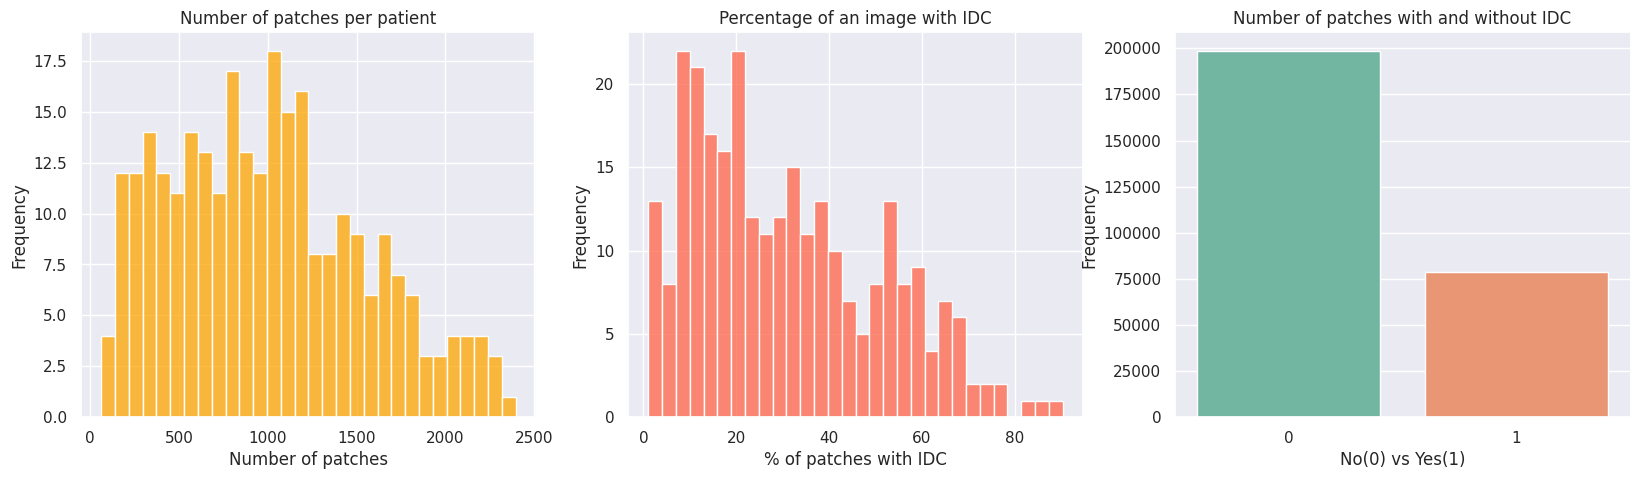

In [11]:
# plotting
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.histplot(df.groupby("patient_id").size(), ax=ax[0], color='Orange', kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Number of patches per patient")

sns.histplot(cancer_plot.loc[:,1]*100, ax=ax[1], color='Tomato', kde=False, bins=30)
ax[1].set_xlabel("% of patches with IDC")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Percentage of an image with IDC")

sns.countplot(x='target', data=df, palette='Set2', ax=ax[2])
ax[2].set_xlabel("No(0) vs Yes(1)")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Number of patches with and without IDC")

plt.show()

#### **Notes:**
1. The number of image patches per patient varies a lot! This leads to the questions **whether all images show the same resolution of tissue cells of if this varies between patients.**
2. Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. **Does a tissue slice per patient cover the whole region of interest?**
3. **The classes of IDC versus no IDC are imbalanced.** We have to check this again after setting up a validation strategy and find a strategy to deal with class weights (if we like to apply them).

## Visualizing healthy and cancerous patches

In [12]:
df.target = df.target.astype(int)

In [13]:
pos_idc = np.random.choice(df[df.target == 1].index.values, size=50, replace=False)
neg_idc = np.random.choice(df[df.target == 0].index.values, size=50, replace=False)

### Cancer Patches

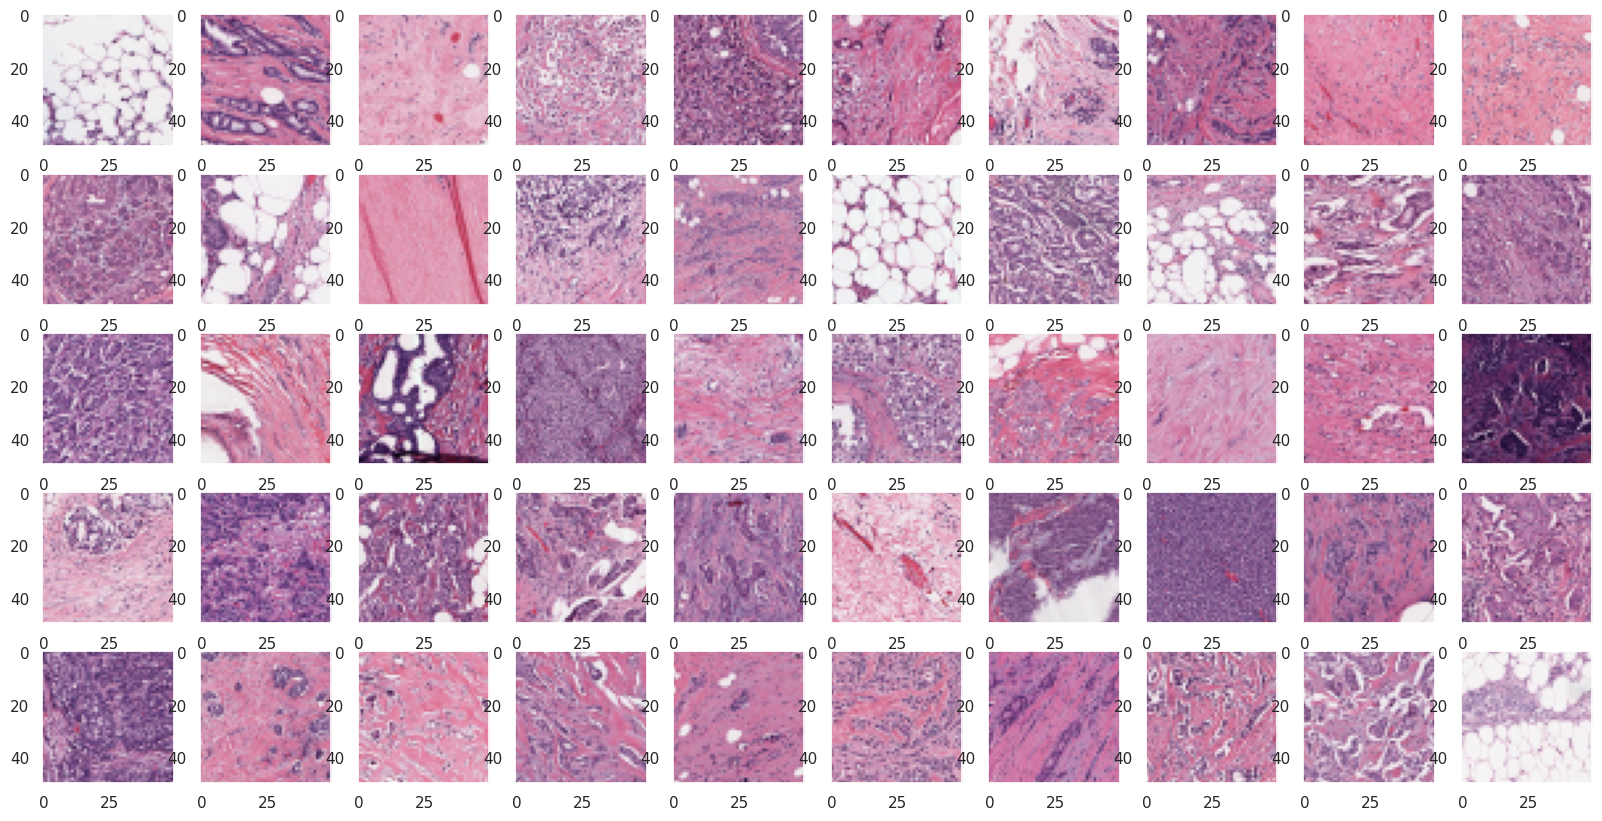

In [14]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_idc[m + 10*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Healthy patches

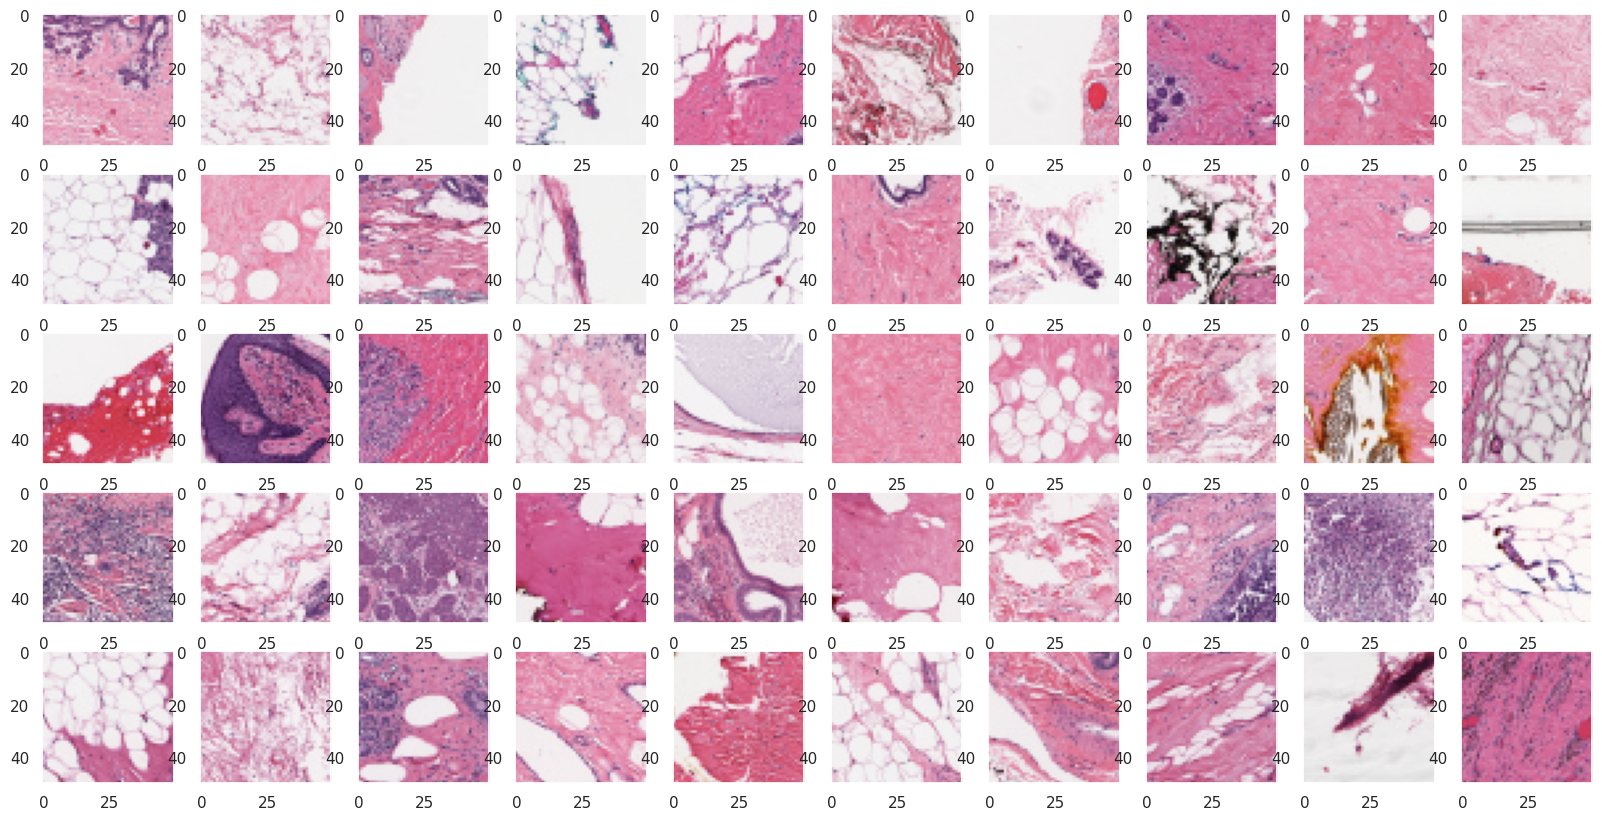

In [15]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_idc[m + 10*n]
        image = imread(df.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

## Reconstructing the breast tissue
This task involves a complex procedure that necessitates the extraction of coordinates from the names of image patches. These coordinates are crucial for the reconstruction of the entire breast tissue for a given patient. Through this reconstruction process, it becomes feasible to conduct a comparative analysis between diseased and healthy tissues. To simplify this task a method that takes a patient and outcomes a dataframe with coordinates and targets is written.

In [16]:
def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    return patient_df

In [17]:
example = get_patient_dataframe(df.patient_id.values[0])
example.head()

x     y  target                                               path
0  1351  1101       0  ../input/breast-histopathology-images/IDC_regu...
1  1501   501       0  ../input/breast-histopathology-images/IDC_regu...
2  1501  1101       0  ../input/breast-histopathology-images/IDC_regu...
3   451   901       0  ../input/breast-histopathology-images/IDC_regu...
4   801   451       0  ../input/breast-histopathology-images/IDC_regu...

### Binary target visualisation per tissue slice

In [ ]:
fig, ax = plt.subplots(5,3,  figsize = (20,27))

patient_ids = df.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m+3*n]
        patient_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(patient_df.x.values, patient_df.y.values, c=patient_df.target.values, cmap="coolwarm", s=20)
        ax[n,m].set_title("Patient" + patient_id)
        ax[n,m].set_xlabel("x")
        ax[n,m].set_ylabel("y")
        
# red => cancer present in those coordinates
# blue => no cancer in those coordinates

In [ ]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = int(example_df.x.values[n])
            y_coord = int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

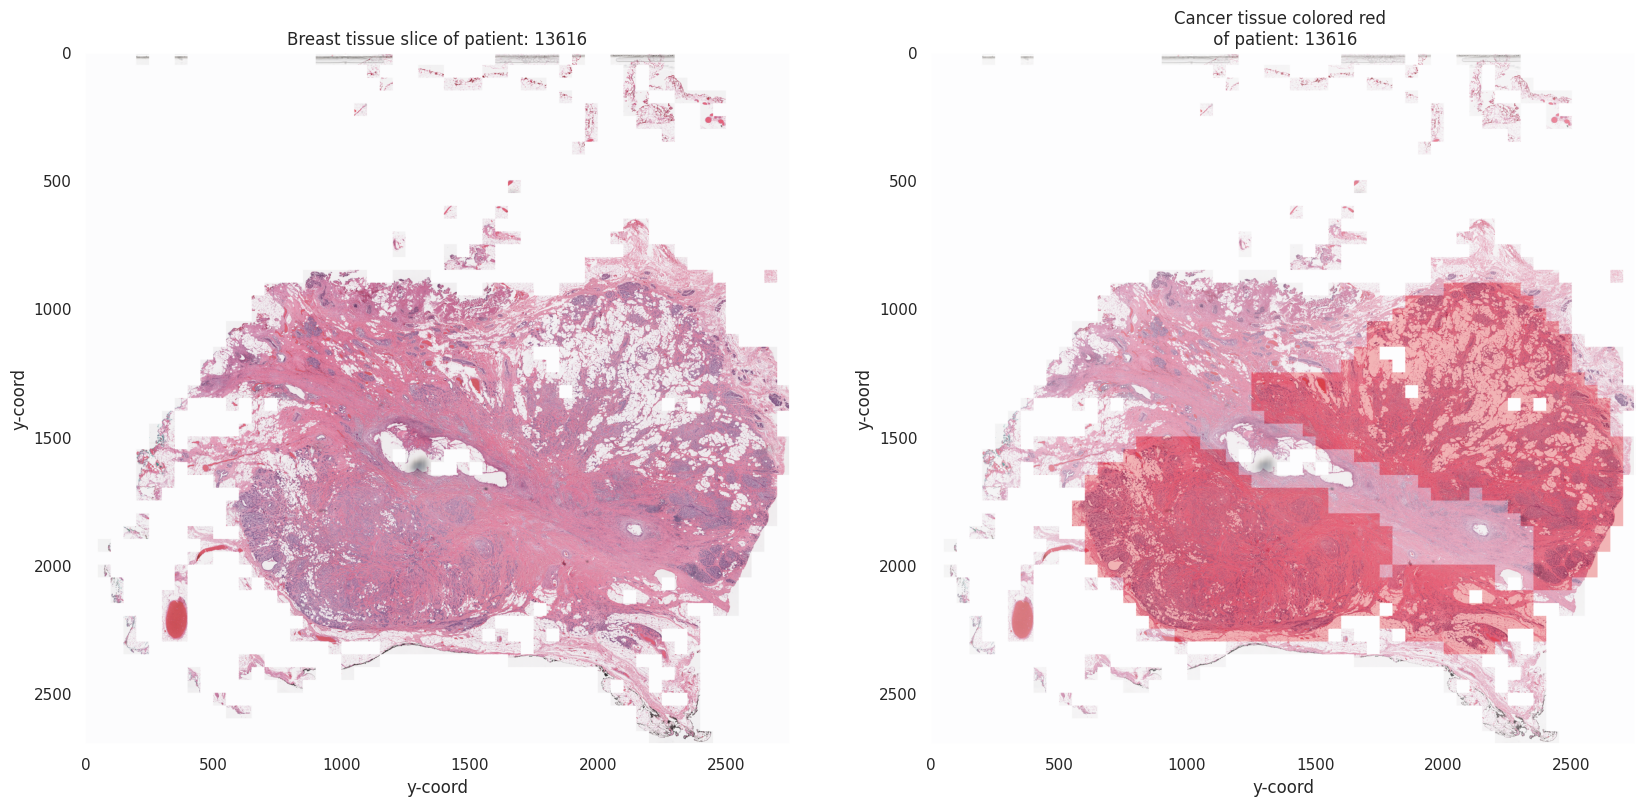

In [20]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + example)
ax[1].set_title("Cancer tissue colored red \n of patient: " + example);

In [21]:
df.head()

patient_id                                               path  target
0      10295  ../input/breast-histopathology-images/IDC_regu...       0
1      10295  ../input/breast-histopathology-images/IDC_regu...       0
2      10295  ../input/breast-histopathology-images/IDC_regu...       0
3      10295  ../input/breast-histopathology-images/IDC_regu...       0
4      10295  ../input/breast-histopathology-images/IDC_regu...       0

### Insights
* The tissue on the left is shown without target information.
* The image on the right shows the same tissue but cancer is stained with intensive red color.
* Comparing both images it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color.
* But as one can see it's not always the case. So we need to ask ourselves if violet tissue patches have more mammary ducts than rose ones. If this is true we have to be careful. Our model might start to learn that mammary ducts are always related to cancer!

# Setting up workflow for ML Model

### Validation Strategy
* 30% -> test data
* 70% -> training and developing data

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df["target"] = df["target"].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 16.5+ MB


In [24]:
df.head()

patient_id                                               path target
0      10295  ../input/breast-histopathology-images/IDC_regu...      0
1      10295  ../input/breast-histopathology-images/IDC_regu...      0
2      10295  ../input/breast-histopathology-images/IDC_regu...      0
3      10295  ../input/breast-histopathology-images/IDC_regu...      0
4      10295  ../input/breast-histopathology-images/IDC_regu...      0

In [25]:
import cv2

In [26]:
# Split data into train+val and test sets
# Randomly select 30,000 images
sampled_df = df.sample(n=50000, random_state=42)  

train_val, test = train_test_split(sampled_df, test_size=0.15, random_state=42)

# Split train+val into train and validation sets
train, val = train_test_split(train_val, test_size=0.1765, random_state=42)  
# 0.1765 is approximately 15% when taken out of 85%


In [27]:
print("Train set size:", len(train))
print("Validation set size:", len(val))
print("Test set size:", len(test))

Train set size: 34998
Validation set size: 7502
Test set size: 7500


In [28]:
train.to_csv('train_dataset.csv', index=False)
val.to_csv('validation_dataset.csv', index=False)
test.to_csv('test_dataset.csv', index=False)

In [29]:
# Create ImageDataGenerators for training and testing/validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators from DataFrames
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='target',
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary'
)

val_generator = test_val_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='path',
    y_col='target',
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='target',
    target_size=(50, 50),
    batch_size=32,
    class_mode='binary'
)

Found 34998 validated image filenames belonging to 2 classes.
Found 7502 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Flatten(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(24, activation='relu'),
    
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [32]:
batch_size = 32
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=40,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 71s 65ms/step - accuracy: 0.8392 - loss: 0.3730 - val_accuracy: 0.8420 - val_loss: 0.3622
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/40


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 69s 63ms/step - accuracy: 0.8438 - loss: 0.3555 - val_accuracy: 0.7109 - val_loss: 1.0062
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 69s 62ms/step - accuracy: 0.8502 - loss: 0.3517 - val_accuracy: 0.7589 - val_loss: 0.7084
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 72s 65ms/step - accuracy: 0.8525 - loss: 0.3401 - val_accuracy: 0.7555 - val_loss: 0.5341
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 72s 66ms/step - accuracy: 0.8563 - loss: 0.3396 - val_accuracy: 0.8494 - val_loss: 0.3490
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━

In [33]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(test_generator)

# Make predictions on new data
predictions = model.predict(test_generator)

  3/235 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.8108 - loss: 0.3927

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8563 - loss: 0.3358
  8/235 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step 

W0000 00:00:1718950954.622395     318 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step


In [34]:
pos_idc_imgs = []
neg_idc_imgs = []

for index, row in df.iterrows():
    # Read the image
    img = cv2.imread(row['path'], cv2.IMREAD_COLOR)
    img_size = cv2.resize(img, (50, 50), interpolation = cv2.INTER_LINEAR)
    
    # Append the image to the appropriate list based on the target value
    if row['target'] == '1':
        pos_idc_imgs.append([img_size,1])
    else:
        neg_idc_imgs.append([img_size,0])
    

In [35]:
print(len(pos_idc_imgs))
print(len(neg_idc_imgs))

78786
198738


In [41]:
neg_idc_imgs = neg_idc_imgs[:78786]

In [42]:
import random
X = []
y = []
total_imgs = pos_idc_imgs + neg_idc_imgs
random.shuffle(total_imgs)
total_imgs = total_imgs
for img_arr, target in total_imgs:
    X.append(img_arr)
    y.append(target)


X = np.array(X)
y = np.array(y)

In [43]:
num_y_equals_1 = np.sum(y == 1)
num_y_equals_0 = np.sum(y == 0)

print("Number of images with y == 1:", num_y_equals_1)
print("Number of images with y == 0:", num_y_equals_0)

Number of images with y == 1: 78786
Number of images with y == 0: 78786


In [44]:
# training, validation and testing data

# First split: Separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Note: By specifying test_size=0.25 in the second split, we're effectively keeping 60% of the data for training,
# 20% for validation, and 20% for testing, since the second split is applied to 80% of the original data.


In [45]:
print(X_train.shape)
print(X_test.shape)

(94542, 50, 50, 3)
(31515, 50, 50, 3)


# Building the Model

In [46]:
# importing necessary librabries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# model = models.Sequential([
#     layers.Input(shape=(50, 50, 3)),
#     layers.Conv2D(32, (3, 3), kernel_initializer = 'he_normal'),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3, 3), kernel_initializer = 'he_normal'),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),
    
#     layers.Conv2D(128, (3, 3), kernel_initializer = 'he_normal'),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),
    
#     layers.Conv2D(128, (3, 3), kernel_initializer = 'he_normal'),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
#     layers.Flatten(),
    
#     layers.Dense(128),
#     layers.BatchNormalization(),  
#     layers.Activation('relu'),
    
#     layers.Dense(1, activation='sigmoid')
# ])

In [ ]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [ ]:
def train_model(X_train, y_train, X_val, y_val, dropout_prob, lr, batch_size, epochs):
    early_stop=EarlyStopping(monitor='val_loss',patience=5)
    model = Sequential([
      Input(shape=(50,50,3)),
      Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      BatchNormalization(),
      Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      MaxPooling2D((2, 2)),
      BatchNormalization(),
      Dropout(dropout_prob),
      Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      BatchNormalization(),
      Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
      Dropout(dropout_prob),
      Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
      Flatten(),
      Dense(128, activation='relu', kernel_initializer='he_uniform'),
      BatchNormalization(),
      Dense(64, activation='relu', kernel_initializer='he_uniform'),
      BatchNormalization(),
      Dense(64, activation='relu', kernel_initializer='he_uniform'),
      Dropout(dropout_prob),
      Dense(24, activation='relu', kernel_initializer='he_uniform'),
      Dense(1, activation='sigmoid'),
      
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0
    )

    return model, history

In [ ]:
# least_val_loss = float('inf')
# least_loss_model = None
# epochs=100
# for dropout_prob in[0, 0.2]:
#     for lr in [0.01, 0.005, 0.001]:
#         for batch_size in [32, 64, 128]:
#             print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
#             model, history = train_model(X_train, y_train, X_val, y_val, dropout_prob, lr, batch_size, epochs)
#             plot_history(history)
#             val_loss = model.evaluate(X_val, y_val)[0]
#             if val_loss < least_val_loss:
#                 least_val_loss = val_loss
#                 least_loss_model = model

In [47]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential([
  Input(shape=(50,50,3)),
  Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  BatchNormalization(),
  Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  MaxPooling2D((2, 2)),
  BatchNormalization(),
  Dropout(0.3),
  Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  BatchNormalization(),
  Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Dropout(0.3),
  Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
  Flatten(),
  Dense(128, activation='relu', kernel_initializer='he_uniform'),
  BatchNormalization(),
  Dense(64, activation='relu', kernel_initializer='he_uniform'),
  BatchNormalization(),
  Dense(64, activation='relu', kernel_initializer='he_uniform'),
  Dropout(0.3),
  Dense(24, activation='relu', kernel_initializer='he_uniform'),
  Dense(1, activation='sigmoid'),

])




In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            2

 Total params: 2,514,385 (9.59 MB)

 Trainable params: 2,513,617 (9.59 MB)

 Non-trainable params: 768 (3.00 KB)

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train, epochs=40, batch_size=35, validation_data=(X_val, y_val),verbose=1
)

Epoch 1/40
  13/2702 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - accuracy: 0.5786 - loss: 0.7607

W0000 00:00:1718952774.157040     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2702/2702 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7835 - loss: 0.4812

W0000 00:00:1718952808.099537     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718952809.482417     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2702/2702 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - accuracy: 0.7836 - loss: 0.4812 - val_accuracy: 0.8313 - val_loss: 0.4123
Epoch 2/40
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.8316 - loss: 0.3933 - val_accuracy: 0.8192 - val_loss: 0.4152
Epoch 3/40
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.8409 - loss: 0.3742 - val_accuracy: 0.8437 - val_loss: 0.3789
Epoch 4/40
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.8438 - loss: 0.3650 - val_accuracy: 0.8392 - val_loss: 0.3718
Epoch 5/40
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.8539 - loss: 0.3440 - val_accuracy: 0.8402 - val_loss: 0.4039
Epoch 6/40
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.8591 - loss: 0.3369 - val_accuracy: 0.8079 - val_loss: 0.4688
Epoch 7/40
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.8640 - loss: 0.3235 - val_accuracy: 0.8584 - val_loss: 0.3529
Epoch 8/40
2702/2702 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.8653 - loss: 0.31

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# optimizer = Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model with early stopping
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=32, callbacks=[early_stopping])
